<table width="100%">
  <tr>
    <td width="50%" align="left">
      <img src="imgs/Brockmann_Consult_Logo_Horizontal_Tagline_1.1.png" alt="Company Logo" style="max-width: 100%; height: auto;" width="300">
    </td>
    <td width="50%" align="right">
      <img src="imgs/logo-light.png" alt="xcube logo" style="max-width: 100%; height: auto;" width="150">
    </td>
  </tr>
</table>

<table width="100%">
  <tr>
    <td width="100%" align="center">
      <h1 style="text-align: center; margin-bottom: 0.3em; font-weight: bold;">
        Building Sentinel-2 Data Cubes
      </h1>
      <div style="height: 0.5em;"></div>
      <h2 style="text-align: center; margin-top: 0; font-weight: bold;">
        Using xcube-stac
      </h2>
    </td>
  </tr>
</table>


**Author(s):** Clara Backens, Konstantin Ntokas, Pontus Lurcock  
**Affiliation:** Brockmann Consult GmbH  
**GitHub:** [xcube-dev/xcube](https://github.com/xcube-dev/xcube), [xcube-dev/xcube-stac](https://github.com/xcube-dev/xcube-stac)   
**Documentation:** [xcube](https://xcube.readthedocs.io/en/latest/), [xcube-stac](https://github.com/xcube-dev/xcube-stac/blob/main/README.md)

---

## Introduction

`xcube-stac` is a Python package and [xcube plugin](https://xcube.readthedocs.io/en/latest/plugins.html) that adds [data stores](https://xcube.readthedocs.io/en/latest/api.html#data-store-framework) which allow to retrieve data organized by a STAC Catalog.



<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea;">
  <strong>Objectives:</strong>
  <ul>
    <li>Get an introduction to a STAC catalog.</li>  
    <li>Get an overview what xcube-stac supports so far.</li>
    <li>Learn how to use xcube-stac to open multiple Sentinel-2 observations as analysis-ready datacubes (ARDC).</li>
    <li>Understand what the algorithm does to generate the ARDC.</li>
  </ul>
</div>

> **Disclaimer**  
> This notebook demonstrates the use of open source software and is intended for educational and illustrative purposes only. All software used is subject to its respective licenses. The authors and contributors of this notebook make no guarantees about the accuracy, reliability, or suitability of the content or included code. Use at your own discretion and risk. No warranties are provided, either express or implied.

---

## Install the xcube-stac Data Store

The xcube-stac package is implemented as a **xcube plugin** and can be installed using `conda/mamba` from the conda-forge channel.

- 🐍 **Conda (conda-forge):** [xcube-stac on Anaconda](https://anaconda.org/conda-forge/xcube-stac) `conda install -c conda-forge xcube-stac`

  You can also use **Mamba** as a faster alternative to Conda: `mamba install -c conda-forge xcube-stac`

---

## General structure of a STAC catalog

A SpatioTemporal Asset Catalog (STAC) consists of three main components:

* **Catalogs**
* **Collections**
* **Items**

An **item** represents a single observation and includes:

* a timestamp or time range
* a spatial bounding box
* one or more assets (e.g., image bands or metadata)

Items in a **collection** share common characteristics (e.g., satellite observations from the same mission). Each item corresponds to one measurement at a specific time and place.

STAC catalogs can be queried by **spatial and temporal extent**, enabling efficient retrieval of only the data relevant to a given area and time.


### General functionality of xcube-stac

The **xcube-stac plugin** provides access to various STAC catalogs via these data stores:

1. `"stac"`: General STAC catalog; opens items whose assets point to remote Zarr, NetCDF, or GeoTIFF sources.
2. `"stac-xcube"`: Datasets from the [xcube server STAC API](https://xcube.readthedocs.io/en/latest/webapi.html).
3. `"stac-cdse"`: For the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en), supporting:

   * [`sentinel-2-l1c`](https://browser.stac.dataspace.copernicus.eu/collections/sentinel-2-l1c)
   * [`sentinel-2-l2a`](https://browser.stac.dataspace.copernicus.eu/collections/sentinel-2-l2a)
   * [`sentinel-3-syn-2-syn-ntc`](https://browser.stac.dataspace.copernicus.eu/collections/sentinel-3-syn-2-syn-ntc)
4. `"stac-cdse-ardc"`: Creates **3D analysis-ready data cubes (ARDCs)** from multiple STAC items of the same CDSE collections.
5. `"stac-pc"`: For the [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/), currently supports:

   * [`sentinel-2-l2a`](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
6. `"stac-pc-ardc"`: Generates ARDCs from multiple STAC items of supported Planetary Computer collections.

> **Note:** The [`xcube-eopf`](https://eopf-sample-service.github.io/xcube-eopf/) plugin (in development) will allow creating 3D ARDCs from [EOPF Sentinel Zarr samples](https://zarr.eopf.copernicus.eu/), which are expected to become the new Sentinel archive standard.

---

In [5]:
from xcube.core.store import new_data_store

First we initialize the data store and for this example we want to use Planetary Computer to access Sentinel-2 Level-2A data. 

In [6]:
store = new_data_store("stac-pc-ardc")

### Open Multiple Sentinel-2 Samples as an Analysis-Ready Data Cube

Sentinel-2 provides multi-spectral imagery at varying native spatial resolutions:

- **10m**: `b02`, `b03`, `b04`, `b08`  
- **20m**: `b05`, `b06`, `b07`, `b8a`, `b11`, `b12`  
- **60m**: `b01`, `b09`, `b10`

Sentinel-2 products are organized as STAC Items, each representing a single tile. These tiles overlap and are stored in their native UTM coordinate reference system (CRS), which varies by geographic location.

![Sentinel-2 Tiles](imgs/sen2_tiles.png)

**Data Cube Generation Workflow**

1. **STAC Query:** A STAC API request returns relevant STAC Items (tiles) based on 
   spatial and temporal extent (`bbox` and `time_range` argument).
2. **Sorting:** Items are ordered by solar acquisition time and Tile ID.
3. **Native Alignment:** Within each UTM zone, tiles from the same solar day are 
   aligned in the native UMT without reprojection. Overlaps are resolved by selecting 
   the first non-NaN pixel value in item order.
4. **Cube Assembly:** The method of a unified cube creation depends on the user's request,
  as summarized in the [xcube-eopf Documentation](https://eopf-sample-service.github.io/xcube-eopf/guide/#sentinel-2)

As an example, we focus on a smaller region around Stavanger, Norway, over a few days in June 2023. Later in this notebook, we outline the steps for processing the full data cube covering all of June 2023 and a larger area, including a significant portion of the ocean.

In [7]:
%%time
ds = store.open_data(
    "sentinel-2-l2a",
    time_range=("2023-06-07", "2023-06-10"),
    bbox=[5.4, 58.7, 6.2, 59.1],
    spatial_res=10 / 111320, # approx. meter to deg
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04", "B08", "SCL"],
    tile_size=(2048, 2048),
)
ds

CPU times: user 3.61 s, sys: 67.5 ms, total: 3.67 s
Wall time: 5.21 s


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 3, lon: 8907, lat: 4454)
Coordinates:
  * time         (time) datetime64[ns] 24B 2023-06-07T10:56:21.024000 ... 202...
  * lon          (lon) float64 71kB 5.4 5.4 5.4 5.4 5.4 ... 6.2 6.2 6.2 6.2 6.2
  * lat          (lat) float64 36kB 59.1 59.1 59.1 59.1 ... 58.7 58.7 58.7 58.7
    spatial_ref  int64 8B 0
Data variables:
    B02          (time, lat, lon) float32 476MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, lat, lon) float32 476MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, lat, lon) float32 476MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08          (time, lat, lon) float32 476MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, lat, lon) uint8 119MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    stac_item_ids:       {'2023-06-07T10:56:21.024000': ['S2A_MSIL2A_20230607...
    stac_catalog_url:    https://planetarycomputer.microsoft.com/api/stac/v1
    xcube_stac_version:  1.1.1

The previous data access was still lazy. To load the data, we plot the first timestamp of the red spectral band. Plotting all 8907×4454 pixels can slow down `matplotlib`, so we use a lower-resolution version for visualization.

CPU times: user 14.7 s, sys: 536 ms, total: 15.3 s
Wall time: 7.36 s


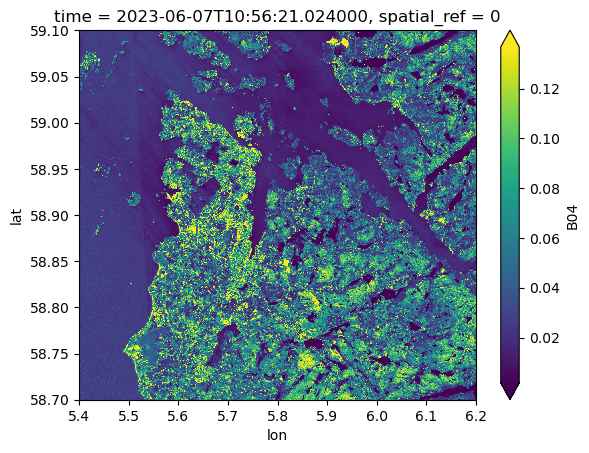

In [8]:
%%time
ds.B04.isel(time=0)[::4, ::9].plot(robust=True)

For the dataset we will explore in the viewer later, we used the following workflow:

```python
from xcube.core.store import new_data_store
import os
import xarray as xr

# Access Planetary Computer (PC)
store = new_data_store("stac-pc-ardc")

# Setup your storage (can also be local)
team_store = new_data_store(
    "s3", 
    root=os.environ["S3_USER_STORAGE_BUCKET"], 
    storage_options=dict(
        anon=False, 
        key=os.environ["S3_USER_STORAGE_KEY"], 
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    )
)

# Split time range into shorter intervals due to PC token expiration (~1 hour)
time_ranges = [
    ("2023-06-01", "2023-06-08"),
    ("2023-06-09", "2023-06-16"),
    ("2023-06-17", "2023-06-24"),
    ("2023-06-25", "2023-06-30"),
]

# Download and store each chunk
for i, time_range in enumerate(time_ranges):
    ds = store.open_data(
        "sentinel-2-l2a",
        time_range=time_range,
        bbox=[4.3, 58.0, 6.5, 59.6],
        spatial_res=10 / 111320,
        crs="EPSG:4326",
        asset_names=["B02", "B03", "B04", "B08", "SCL"],
        tile_size=(2048, 2048),
    )
    team_store.write_data(ds, f"sen2_l2a_{i}.zarr", replace=True)

# Concatenate along the time axis
dss = [team_store.open_data(f"sen2_l2a_{i}.zarr") for i in range(4)]
ds = xr.concat(dss, dim="time")
team_store.write_data(ds, "sen2_l2a.levels", num_levels=5)
```

**Notes:**

* The full workflow takes roughly **3 hours**.
* Shorter time ranges are necessary because the Planetary Computer token expires after one hour; all data access and writes must complete within this window.
* Future xcube-stac release may implement this workflow and thus, support direct access to large cubes, avoiding the need for manual splitting.


---

<table width="100%">
  <tr>
    </td>
    <td width="20%"></td>
    <td width="60%" align="center" style="font-size: 0.9em; color: #666; vertical-align: middle;">
      &copy; 2025 Brockmann Consult GmbH &nbsp;|&nbsp;
      <a href="https://www.brockmann-consult.de" target="_blank">Website</a>
    <td width="20%" align="right" style="vertical-align: middle;">
      <img src="imgs/Brockmann_Consult_Logo_Horizontal_1.1.png" alt="Company Logo" width="150">
    </td>
  </tr>
</table>